In [11]:
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# reading the data
df = pd.read_csv('./data/SAP Dataset 2016-2021 - XETRA EUR.csv')
data = df.sort_index(ascending=True, axis=0)

train = data[:1014]
valid = data[1014:]

In [13]:
training = train['Close']
validation = valid['Close']

model = pm.auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=253)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.58 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4635.920, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4442.937, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4633.551, Time=0.18 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4304.514, Time=0.91 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.46 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4309.134, Time=0.52 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4304.979, Time=0.93 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=4305.789, Time=1.15 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=4305.070, Time=0.66 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=4304.287, Time=1.62 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=4443.475, Time=0.73 sec
 ARIMA(2,1,1)(2,1,1)[12]             : 

In [17]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

203.84827725795853

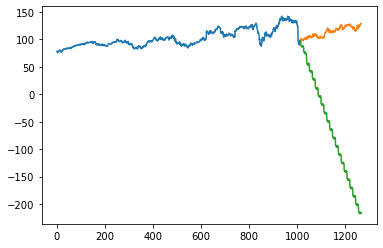

In [15]:
#plot
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])